In [1]:
try: import fastkaggle
except ModuleNotFoundError:
  !pip install -Uqq fastkaggle
from fastkaggle import *

In [2]:
!pip install -Uqq fastai

In [3]:
from fastai.vision.all import *

In [4]:
from pathlib import Path
path  = Path.cwd().parent
path

Path('/notebooks/paddydoctor')

### Set training folder path

In [5]:
trn_path = path/"data"/"train_images"

In [6]:
files = get_image_files(trn_path)

In [7]:
files

(#10407) [Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/109162.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/109183.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/101765.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/101592.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/104770.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/110190.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/106643.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/104269.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/108023.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/107676.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacterial_panicle_blight/100694.jpg'),Path('/notebooks/paddydoctor/data/train_images/bacteria

### Check one image

In [8]:
img = PILImage.create(files[0])
print(img.size)

(480, 640)


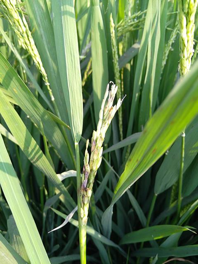

In [9]:
img.to_thumb(264)

### Check the size of all images in parallel

In [10]:
# from fastcore.parallel import *
# def f(o):
#     return PILImage.create(o).size
# sizes = parallel(f, files, n_workers=8)
# pd.Series(sizes).value_counts()

### Data Loading and Transformation

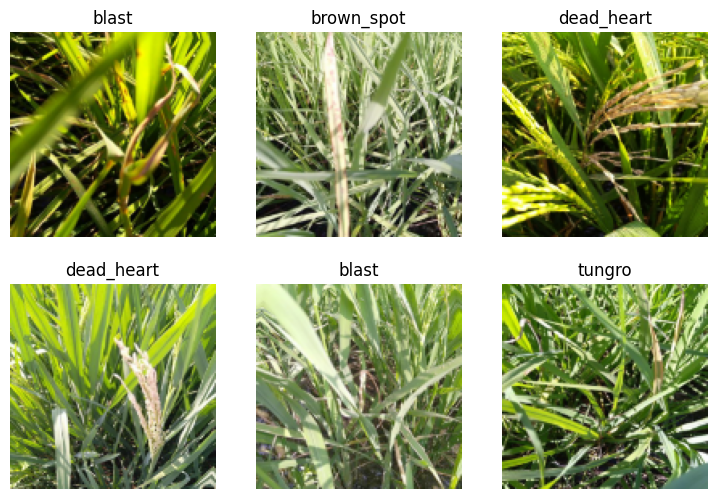

In [11]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
                                   item_tfms = Resize(480, method='squish'),
                                   batch_tfms = aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n = 6)

### Training the Model

In [34]:
# learn = vision_learner(dls, "resnet26d", metrics=error_rate,path=".").to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575, slide=0.001737800776027143)

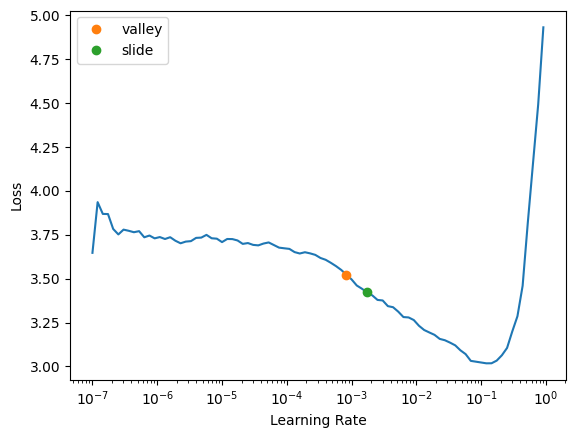

In [35]:
# learn.lr_find(suggest_funcs= (valley, slide))

In [36]:
# learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.781128,1.172874,0.376261,00:45


epoch,train_loss,valid_loss,error_rate,time
0,1.133446,0.826360,0.286881,00:49
1,0.794634,0.483602,0.156175,00:47
2,0.554034,0.383567,0.125901,00:44


In [38]:
# learn.export(path/'models'/'model_v1.pkl')

### Submitting v1 to kaggle

In [39]:
ss_v1 = pd.read_csv(path/'data'/'sample_submission.csv')
ss_v1

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [40]:
test_files = get_image_files(path/'data'/'test_images').sorted()

In [41]:
tst_dls = dls.test_dl(test_files)

In [42]:
learn = load_learner("/notebooks/paddydoctor/models/model_v1.pkl")

In [43]:
prob,_,idxs = learn.get_preds(dl = tst_dls, with_decoded=True)
idxs

tensor([7, 8, 4,  ..., 8, 1, 5])

In [44]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [45]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name = 'idxs').map(mapping)
results

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [46]:
ss_v1['label'] = results
ss_v1.to_csv(path/'data'/'subm_v1.csv',index=False)

### V2 - Smaller Images

In [47]:
sml_img_trn_path = Path(path/'data'/'sml_train_images')

In [48]:
# resize_images(path/'data'/'train_images', dest=sml_img_trn_path, max_size=256, recurse=True)

In [7]:
def train(training_path,arch,item,batch, metric ,epochs = 5):
    dls = ImageDataLoaders.from_folder(training_path,seed=42,valid_pct=0.2,item_tfms=item,batch_tfms=batch)
    learn = vision_learner(dls=dls, arch=arch, metrics= metric).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [16]:
# learn = train(sml_img_trn_path, 'resnet26d',item=Resize(192), batch=aug_transforms(size=128,min_scale=0.75),metric=error_rate)

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.922584,1.423786,0.469966,00:32


epoch,train_loss,valid_loss,error_rate,time
0,1.294089,1.018125,0.344065,00:34
1,1.019353,0.696663,0.224411,00:32
2,0.693442,0.447029,0.143200,00:31
3,0.543317,0.355729,0.114368,00:31
4,0.431546,0.340031,0.110043,00:30


### A ConvNeXt model

In [9]:
arch = 'convnext_small.fb_in22k'

In [20]:
# learn = train(sml_img_trn_path, arch,item=Resize(192, method = 'squish'), batch=aug_transforms(size=128,min_scale=0.75),metric=error_rate)

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.292272,0.755187,0.251321,03:08


epoch,train_loss,valid_loss,error_rate,time
0,0.657785,0.424070,0.134070,03:28
1,0.497068,0.318181,0.093224,03:30
2,0.304691,0.203778,0.067275,03:29
3,0.190306,0.144838,0.044210,03:29
4,0.129702,0.136107,0.039885,03:29


In [21]:
# learn.export(path/'models'/'model_v2.pkl')

In [52]:
learn = load_learner(path/'models'/'model_v2.pkl')

### Preprocessing experiments

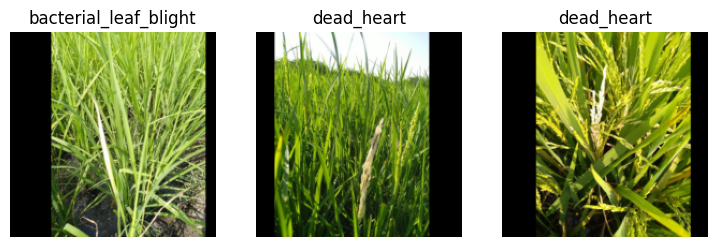

In [53]:
# Adding padding
dls = ImageDataLoaders.from_folder(trn_path, valid_pct = 0.2, seed = 42,
                                  item_tfms= Resize(192, ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n = 3)

In [55]:
# learn  = train(sml_img_trn_path, arch, item = Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch = aug_transforms(size=(171,128), min_scale=0.75),metric=error_rate)

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.429070,1.002162,0.307544,03:28


epoch,train_loss,valid_loss,error_rate,time
0,0.721915,0.463301,0.150408,03:53
1,0.535034,0.370897,0.116290,03:53
2,0.353079,0.216080,0.064873,03:53
3,0.200170,0.169143,0.054781,03:53
4,0.158077,0.157819,0.049495,03:53


In [56]:
# learn.export(path/'models'/'model_v2_padding.pkl')

In [57]:
learn = load_learner(path/'models'/'model_v2_padding.pkl')

In [59]:
tst_dls = dls.test_dl(test_files)

In [60]:
prob,_,idxs = learn.get_preds(dl = tst_dls, with_decoded=True)

In [61]:
ss_v2 = pd.read_csv(path/'data'/'sample_submission.csv')

In [62]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name = 'idxs').map(mapping)

In [63]:
ss_v2['label'] = results
ss_v2.to_csv(path/'data'/'subm_v2.csv',index=False)

In [71]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [72]:
report_gpu()

GPU:0
process     159190 uses     1810.000 MB GPU memory


### Submitting on original files

In [ ]:
learn = train(trn_path, arch= arch,epochs=12, item=Resize((480,360), method = ResizeMethod.Pad, pad_mode=PadMode.Zeros),
             batch=aug_transforms(size = (256,192), min_scale=0.75), metric=error_rate)

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.120833,0.622027,0.203268,05:35


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
learn.export(path/'models'/'model_v2_padding_org.pkl')